In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [5]:
tf.__version__

'2.12.0'

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 100
CHANNELS=3
EPOCHS=50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Ved1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 15339 files belonging to 7 classes.


In [9]:
class_names = dataset.class_names
class_names

['0', '1', '2', '3', '4', '5', '6']

In [10]:
len(dataset)

480

In [11]:
480*32

15360

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 100, 100, 3)
[6 6 3 0 3 4 3 6 4 3 3 2 4 5 4 0 6 3 5 6 2 3 4 5 3 2 4 3 3 6 0 0]


In [13]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[126.  66.  40.]
  [128.  68.  42.]
  [133.  71.  46.]
  ...
  [  2.   2.   2.]
  [  2.   2.   2.]
  [  2.   2.   2.]]

 [[131.  69.  44.]
  [134.  72.  47.]
  [138.  76.  51.]
  ...
  [  2.   2.   2.]
  [  2.   2.   2.]
  [  2.   2.   2.]]

 [[139.  75.  48.]
  [143.  79.  52.]
  [148.  84.  57.]
  ...
  [  2.   2.   2.]
  [  2.   2.   2.]
  [  2.   2.   2.]]

 ...

 [[157. 104.  72.]
  [158. 105.  73.]
  [159. 106.  74.]
  ...
  [  4.   4.   6.]
  [  4.   4.   6.]
  [  7.   7.   9.]]

 [[155. 102.  70.]
  [154. 101.  69.]
  [153. 100.  68.]
  ...
  [  8.   8.  10.]
  [  5.   5.   7.]
  [  7.   7.   9.]]

 [[154. 101.  69.]
  [152.  99.  67.]
  [151.  98.  66.]
  ...
  [ 12.  12.  14.]
  [  8.   8.  10.]
  [  8.   8.  10.]]]


In [14]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape)

(100, 100, 3)


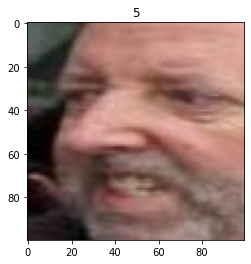

In [15]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
#     plt.axis("off")

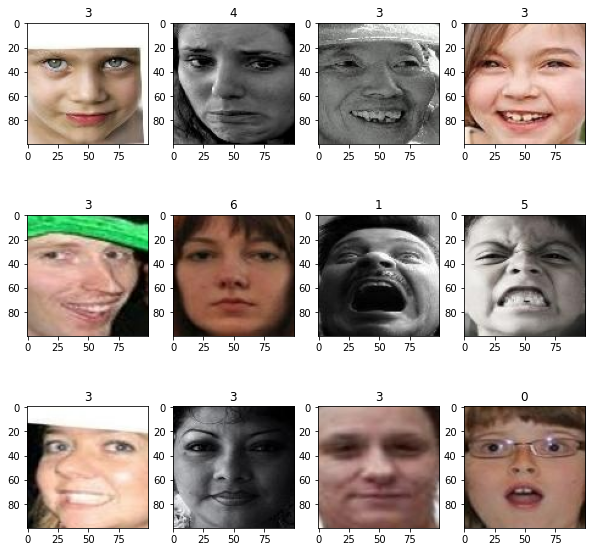

In [16]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
#         plt.axis("off")


In [17]:
len(dataset)

480

In [26]:

train_size = 0.8
len(dataset)*train_size

384.0

In [27]:
train_ds = dataset.take(384)
len(train_ds)

384

In [28]:
test_ds = dataset.skip(384)
len(test_ds)

96

In [29]:
val_size=0.1
len(dataset)*val_size

48.0

In [30]:
val_ds = test_ds.take(48)
len(val_ds)

48

In [31]:
test_ds = test_ds.skip(48)
len(test_ds)

48

In [32]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [33]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [34]:
len(train_ds)

384

In [35]:
len(val_ds)

48

In [36]:
len(test_ds)

48

In [54]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [55]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [56]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [61]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [62]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 98, 98, 32)          896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 49, 49, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 47, 47, 64)          18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 23, 23, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 21, 21, 64)         

In [63]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [64]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
384/384 [==============================] - 102s 260ms/step - loss: 1.5865 - accuracy: 0.4102 - val_loss: 1.3498 - val_accuracy: 0.5130
Epoch 2/50
384/384 [==============================] - 93s 242ms/step - loss: 1.1724 - accuracy: 0.5741 - val_loss: 1.0375 - val_accuracy: 0.6276
Epoch 3/50
384/384 [==============================] - 89s 233ms/step - loss: 0.9277 - accuracy: 0.6674 - val_loss: 0.8424 - val_accuracy: 0.6940
Epoch 4/50
384/384 [==============================] - 90s 234ms/step - loss: 0.8110 - accuracy: 0.7070 - val_loss: 0.7788 - val_accuracy: 0.7201
Epoch 5/50
384/384 [==============================] - 90s 234ms/step - loss: 0.7333 - accuracy: 0.7363 - val_loss: 0.7044 - val_accuracy: 0.7572
Epoch 6/50
384/384 [==============================] - 89s 232ms/step - loss: 0.6622 - accuracy: 0.7639 - val_loss: 0.6417 - val_accuracy: 0.7832
Epoch 7/50
384/384 [==============================] - 89s 231ms/step - loss: 0.6146 - accuracy: 0.7779 - val_loss: 0.6110 - val_a

In [65]:
scores = model.evaluate(test_ds)

48/48 [==============================] - 11s 47ms/step - loss: 0.6432 - accuracy: 0.9141


In [66]:
scores

[0.6431766152381897, 0.9140625]

In [67]:

history

In [68]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 384}

In [69]:

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [70]:

type(history.history['loss'])

list

In [71]:
len(history.history['loss'])

50

In [72]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.5865187644958496,
 1.1723713874816895,
 0.9277193546295166,
 0.8110079169273376,
 0.7333011627197266]

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

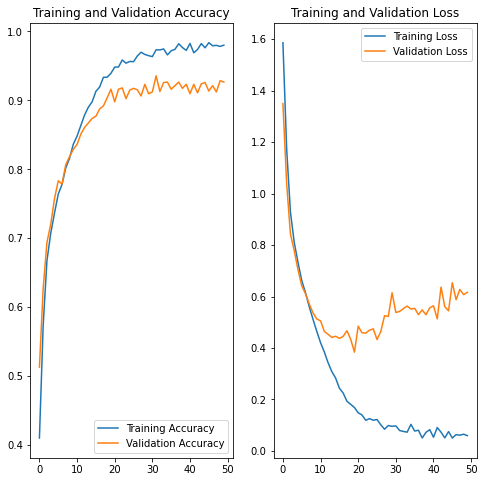

In [74]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: 3
1/1 [==============================] - 1s 626ms/step
predicted label: 3


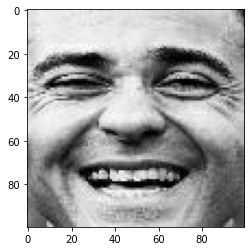

In [75]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [76]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


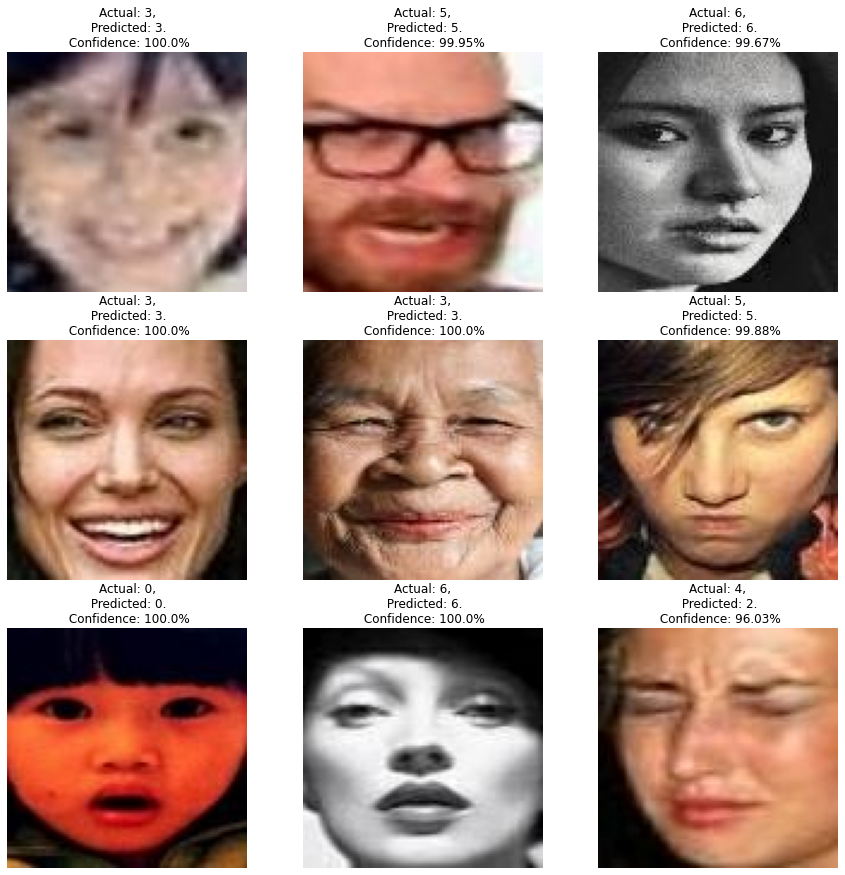

In [77]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [52]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"C:/Users/HARSHAL/models/{model_version}")

INFO:tensorflow:Assets written to: C:/Users/HARSHAL/models/6\assets


INFO:tensorflow:Assets written to: C:/Users/HARSHAL/models/6\assets


In [78]:

model.save("A-98-VA-92-RAF.h5")

In [3]:
model = tf.keras.models.load_model("A-98-VA-92-RAF.h5")

first image to predict
actual label: 3
1/1 [==============================] - 0s 239ms/step
predicted label: 3


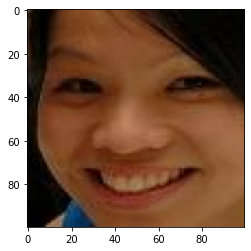

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [57]:
# plt.figure(figsize=(15, 15))
# count=0
# # for j in range(48):
#     for images, labels in test_ds.take(1):
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(images[i].numpy().astype("uint8"))
#             predicted_class, confidence = predict(model, images[i].numpy())
#             actual_class = class_names[labels[i]] 
#             if(predicted_class==actual_class):
#                 count=count+1;
# ta=count/(1536)
# print("Testing Accuracy of our model is =>",ta)
        
#         plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
#         plt.axis("off")
count=0
total=0
plt.figure(figsize=(15, 15))
# for j in range(2):
for images, labels in test_ds.take(48):
    for i in range(32):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        if(predicted_class==actual_class):
            count=count+1
        total=total+1
#         plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

#         plt.axis("off")

ta=count/(total) 
print("Total testing images =>",total)
print("Testing Accuracy of our model is =>",ta)

1/1 [==============================] - 0s 62ms/step
Total testing images => 1536
Testing Accuracy of our model is => 0.935546875


<Figure size 1080x1080 with 0 Axes>

In [ ]:
len(test_ds)

In [ ]:
48*32

In [58]:
ta=count/(total)
print("Testing Accuracy of our model is =>",ta)

Testing Accuracy of our model is => 0.935546875
